## 1 — Environment check (imports & versions)

In [1]:
import sys, numpy, pandas, matplotlib, sklearn, tensorflow as tf
import tensorflow_data_validation as tfdv
print("Python:", sys.version.split()[0])
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)
print("TFDV:", tfdv.__version__)



Python: 3.10.18
NumPy: 1.26.4
Pandas: 1.5.3
Matplotlib: 3.7.5
scikit-learn: 1.3.2
TensorFlow: 2.18.0
TFDV: 1.14.0


## 2 — Helper imports, plotting style & warnings config


In [2]:
import os, gc, warnings, urllib.request
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder

import tensorflow_data_validation as tfdv
from tensorflow_metadata.proto.v0 import schema_pb2

plt.rcParams["figure.figsize"] = (8, 5)
plt.style.use("ggplot")

print("Pandas:", pd.__version__)
print("TFDV:", tfdv.__version__)

Pandas: 1.5.3
TFDV: 1.14.0


## 3 — Config & I/O (paths, columns, downloader)


In [3]:
DATA_DIR = "taxi2020"
os.makedirs(DATA_DIR, exist_ok=True)

BASE_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data"
FNAME = "yellow_tripdata_2020-{}.parquet"

# Only columns allowed by the brief
COLUMNS = [
    "tpep_pickup_datetime", "tpep_dropoff_datetime",
    "passenger_count", "trip_distance",
    "PULocationID", "DOLocationID",
    "fare_amount", "tip_amount", "tolls_amount", "total_amount",
    "extra", "mta_tax", "improvement_surcharge", "congestion_surcharge",
    "payment_type", "VendorID", "RatecodeID"
]

def fetch_parquet(month_str):
    url  = f"{BASE_URL}/{FNAME.format(month_str)}"
    path = os.path.join(DATA_DIR, FNAME.format(month_str))
    if not os.path.exists(path):
        print("Downloading", url)
        urllib.request.urlretrieve(url, path)
    return path

## 4 — Load months (read_subset) & show shapes


In [4]:
mar_path = fetch_parquet("03")
may_path = fetch_parquet("05")
# Extra credit baseline:
jan_path = fetch_parquet("01")  # only if you’ll do Jan vs Mar

def read_subset(path, cols):
    df = pd.read_parquet(path, columns=cols)  # pyarrow default
    df["tpep_pickup_datetime"]  = pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")
    df["month"] = df["tpep_pickup_datetime"].dt.month
    return df

mar_raw = read_subset(mar_path, COLUMNS)
may_raw = read_subset(may_path, COLUMNS)
jan_raw = read_subset(jan_path, COLUMNS)  # optional

mar_raw.shape, may_raw.shape, jan_raw.shape

((3007687, 18), (348415, 18), (6405008, 18))

## 5 — Data cleaning/feature prep (prep()) + prepared shapes


In [5]:
def prep(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Duration (minutes)
    df["trip_duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60.0

    # Convert monetary fields to numeric (coerce)
    money_cols = ["fare_amount", "tip_amount", "tolls_amount", "total_amount",
                  "extra", "mta_tax", "improvement_surcharge", "congestion_surcharge"]
    for c in money_cols:
        if c in df:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Basic validity + coarse outliers
    df = df[
        (df["trip_distance"] > 0) & (df["trip_distance"] <= 150) &
        (df["trip_duration_min"] > 0) & (df["trip_duration_min"] <= 360) &
        (df["fare_amount"] > 0)
    ]

    # Speed (mph) sanity, then drop the helper
    df["avg_mph"] = 60.0 * df["trip_distance"] / df["trip_duration_min"]
    df = df[(df["avg_mph"] > 1) & (df["avg_mph"] <= 80)]

    # Fill small fields; passengers zero→1
    small = ["extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","congestion_surcharge"]
    for c in small:
        if c in df:
            df[c] = df[c].fillna(0)

    if "passenger_count" in df:
        df["passenger_count"] = pd.to_numeric(df["passenger_count"], errors="coerce").fillna(1).replace(0,1)

    # Tip rate (will be used in KPIs)
    if {"fare_amount","tip_amount"}.issubset(df.columns):
        df["tip_rate"] = np.where(df["fare_amount"] > 0, df["tip_amount"] / df["fare_amount"], 0.0)

    # Keep only fields we’ll analyze (brief scope)
    final_cols = [
        "month","VendorID","RatecodeID","payment_type",
        "PULocationID","DOLocationID",
        "passenger_count","trip_distance","trip_duration_min","avg_mph",
        "fare_amount","tip_amount","tolls_amount","total_amount",
        "extra","mta_tax","improvement_surcharge","congestion_surcharge","tip_rate"
    ]
    df = df[[c for c in final_cols if c in df.columns]].copy()

    # Dtypes downcast (memory friendly)
    int_like = ["VendorID","payment_type","PULocationID","DOLocationID","passenger_count","month"]
    for c in int_like:
        if c in df: df[c] = pd.to_numeric(df[c], downcast="integer")
    float_like = [c for c in df.columns if c not in int_like]
    for c in float_like:
        df[c] = pd.to_numeric(df[c], downcast="float")

    return df

mar = prep(mar_raw)
may = prep(may_raw)
jan = prep(jan_raw)  # optional

mar.shape, may.shape, jan.shape

((2955781, 19), (335709, 19), (6294833, 19))

## 6 — Quick schema peek (numeric / categorical listing)


In [6]:
def type_listing(df: pd.DataFrame, label=""):
    numeric = df.select_dtypes(include=np.number).columns.tolist()
    # datetimes are not in final set (we engineered duration), so leave empty by design
    datetimes = []
    categorical = [c for c in df.columns if c not in numeric + datetimes]
    print(f"==== Types in {label} ====")
    print("Numeric:", numeric)
    print("Categorical:", categorical)
    print("Datetime:", datetimes)

type_listing(mar, "March 2020")
type_listing(may, "May 2020")

==== Types in March 2020 ====
Numeric: ['month', 'VendorID', 'RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'trip_duration_min', 'avg_mph', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'tip_rate']
Categorical: []
Datetime: []
==== Types in May 2020 ====
Numeric: ['month', 'VendorID', 'RatecodeID', 'payment_type', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'trip_duration_min', 'avg_mph', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'tip_rate']
Categorical: []
Datetime: []


## 7 — Distributions (histograms for key numeric fields)


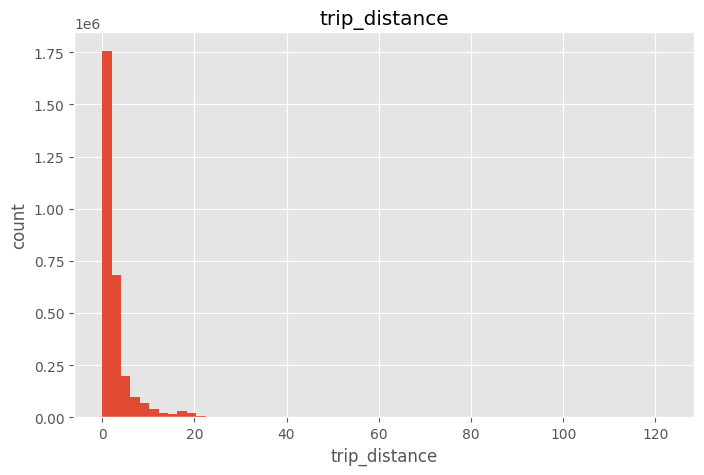

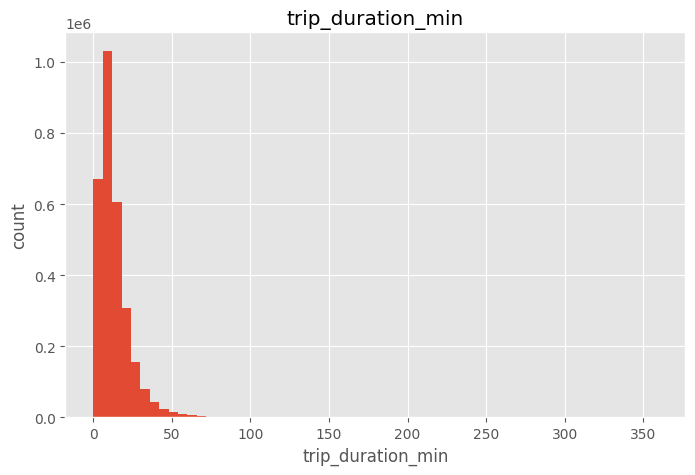

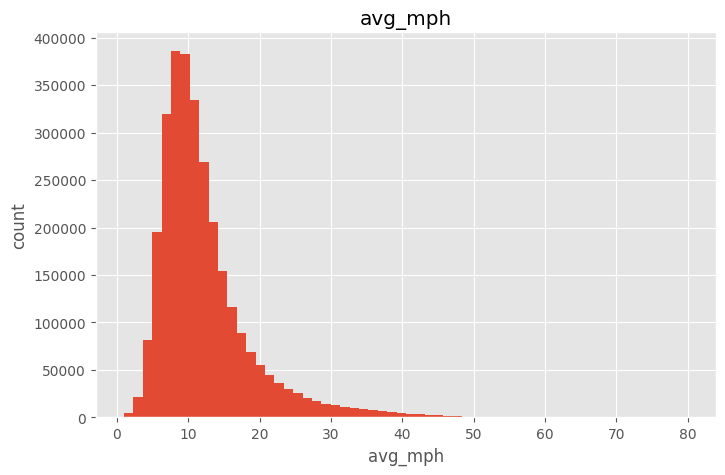

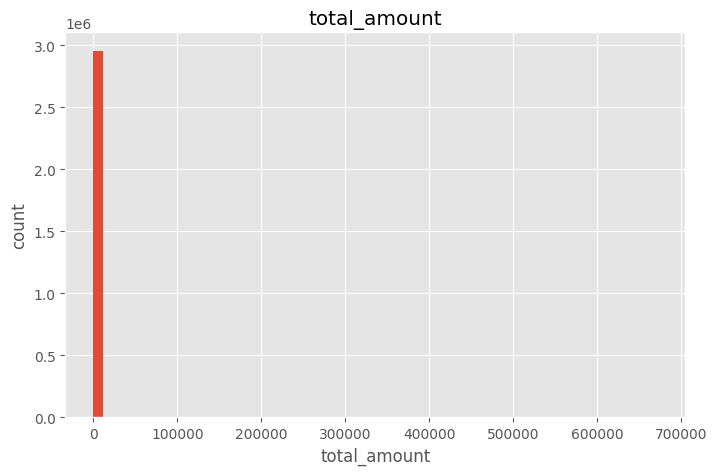

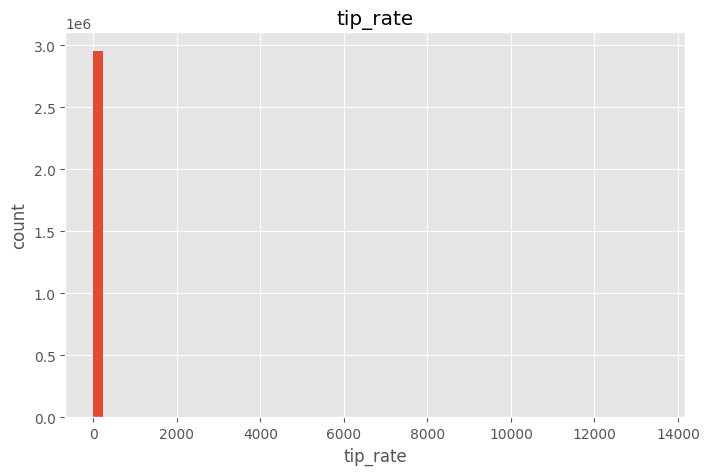

In [7]:
def hist_series(s, bins=60, title=None, xlab=None):
    s = pd.Series(s).dropna()
    plt.figure()
    plt.hist(s, bins=bins)
    plt.title(title or s.name)
    plt.xlabel(xlab or s.name)
    plt.ylabel("count")
    plt.show()

for col in ["trip_distance","trip_duration_min","avg_mph","total_amount","tip_rate"]:
    if col in mar:
        hist_series(mar[col], bins=60, title=col, xlab=col)

## 8 — Correlation heatmap (March 2020, numeric)


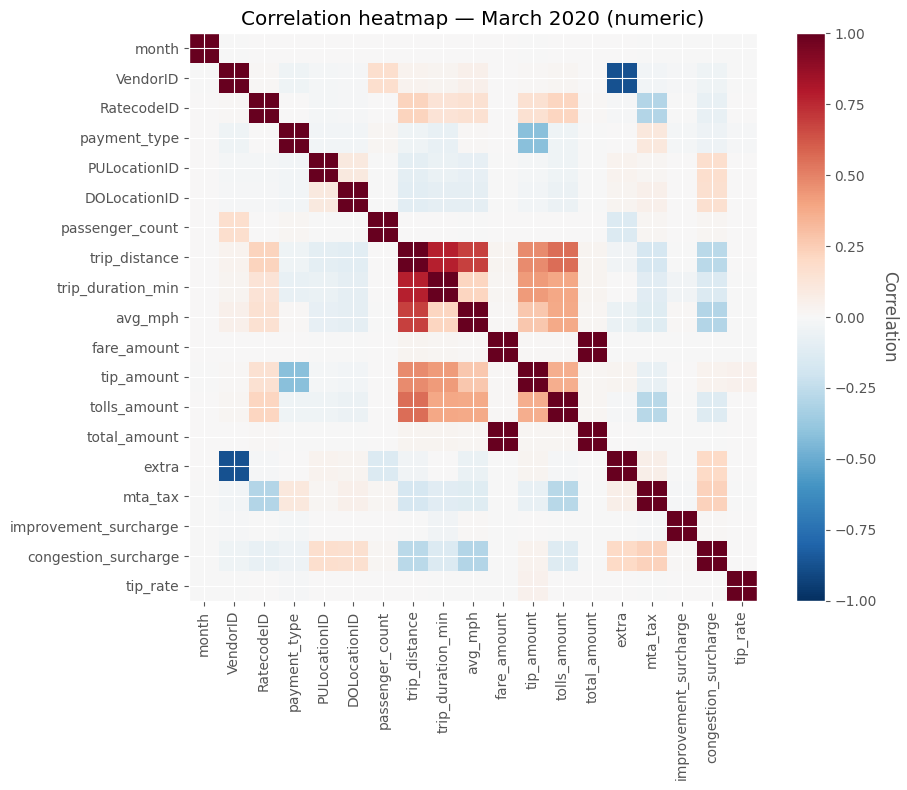

In [8]:
num = mar.select_dtypes(include=np.number)
corr = num.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
im = plt.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1, interpolation="nearest")  # or cmap="coolwarm"
plt.xticks(range(len(num.columns)), num.columns, rotation=90)
plt.yticks(range(len(num.columns)), num.columns)
cbar = plt.colorbar(im)
cbar.set_label("Correlation", rotation=270, labelpad=15)
plt.title("Correlation heatmap — March 2020 (numeric)")
plt.tight_layout()
plt.show()

## 9 — Feature importance for duration (mutual information)


In [9]:
TARGET = "trip_duration_min"

# 1) Choose candidate features (skip heavy/redundant columns for speed)
#    - Location IDs are high-cardinality; fare subcomponents are redundant for time prediction.
skip_cols = {"PULocationID","DOLocationID","total_amount","fare_amount",
             "extra","mta_tax","improvement_surcharge"}  # still available elsewhere in EDA
candidates = [c for c in mar.columns if c != TARGET and c not in skip_cols]

# 2) Build a working frame and take a reasonable sample
work = mar[candidates + [TARGET]].dropna()
sample_n = min(200_000, len(work))       # adjust to 150k–300k if you want
work = work.sample(sample_n, random_state=42)

X = work.drop(columns=[TARGET])
y = work[TARGET].values

# 3) Tell MI which features are discrete (speeds it up & improves estimates)
discrete = []
for c in X.columns:
    is_int = np.issubdtype(X[c].dtype, np.integer)
    low_card = X[c].nunique() <= 50     # treat low-cardinality ints as discrete
    discrete.append(bool(is_int and low_card))

# 4) Run MI (smaller n_neighbors is faster; 3–5 is fine)
mi = mutual_info_regression(
    X, y, discrete_features=discrete, n_neighbors=5, random_state=0
)

fi = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Feature importance (mutual information) wrt trip_duration_min — March 2020")
display(fi.head(15))

Feature importance (mutual information) wrt trip_duration_min — March 2020


avg_mph                 0.956302
trip_distance           0.803277
tip_amount              0.689309
tip_rate                0.647783
tolls_amount            0.076573
RatecodeID              0.055047
congestion_surcharge    0.021546
month                   0.000000
VendorID                0.000000
payment_type            0.000000
passenger_count         0.000000
dtype: float64

## 10 — TFDV: stats, schema inference & anomaly check


In [10]:
# Sample to keep visuals responsive
mar_stats = tfdv.generate_statistics_from_dataframe(mar.sample(min(300_000, len(mar)), random_state=1))
may_stats = tfdv.generate_statistics_from_dataframe(may.sample(min(300_000, len(may)), random_state=1))

# Side-by-side distributions
tfdv.visualize_statistics(lhs_statistics=mar_stats, rhs_statistics=may_stats,
                          lhs_name="March 2020", rhs_name="May 2020")

# Infer schema from train (March), validate eval (May)
schema = tfdv.infer_schema(mar_stats)
tfdv.display_schema(schema)
anomalies = tfdv.validate_statistics(statistics=may_stats, schema=schema)
tfdv.display_anomalies(anomalies)

,Type,Presence,Valency,Domain
Feature name,,,,
'month',INT,required,,-
'VendorID',INT,required,,-
'RatecodeID',FLOAT,optional,single,-
'payment_type',INT,required,,-
'PULocationID',INT,required,,-
'DOLocationID',INT,required,,-
'passenger_count',INT,required,,-
'trip_distance',FLOAT,required,,-
'trip_duration_min',FLOAT,required,,-


## 11 — KPI comparison: March vs May 2020 (+ charts & delta)


,trips,avg_distance,avg_duration,avg_mph,avg_total,median_tip
Mar(3),2955781.0,2.914,13.139,12.193,18.476,0.233
May(5),335709.0,3.812,11.919,16.746,18.437,0.065


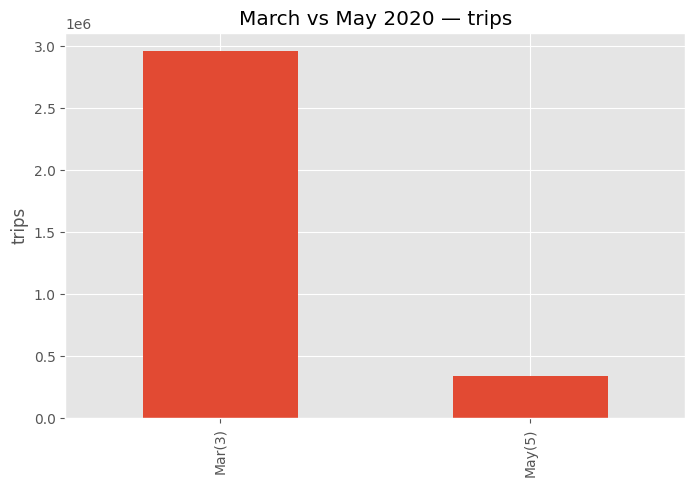

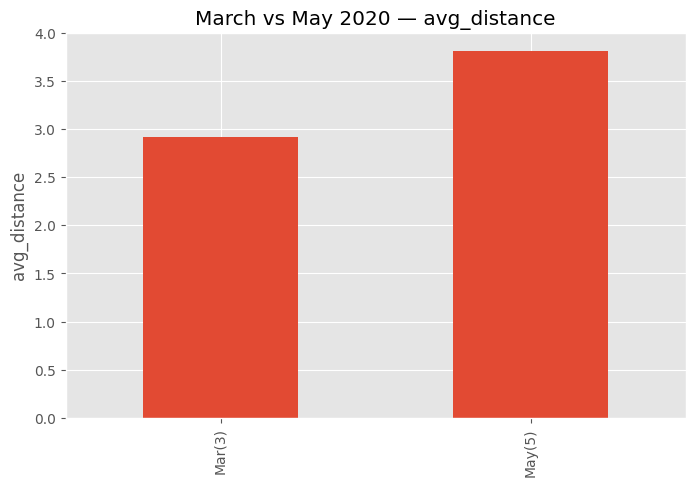

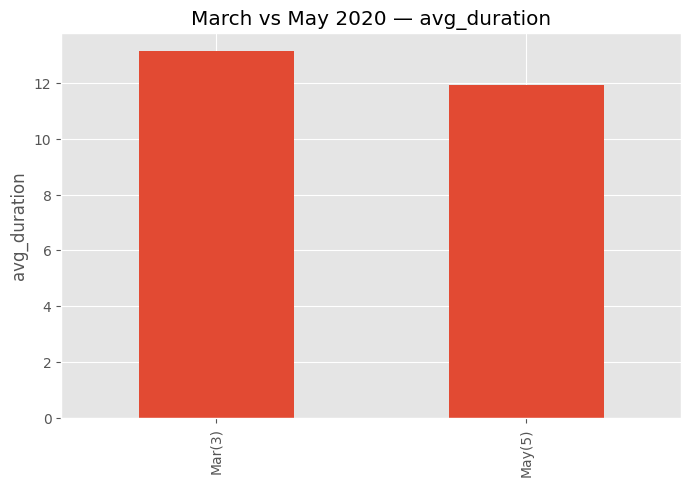

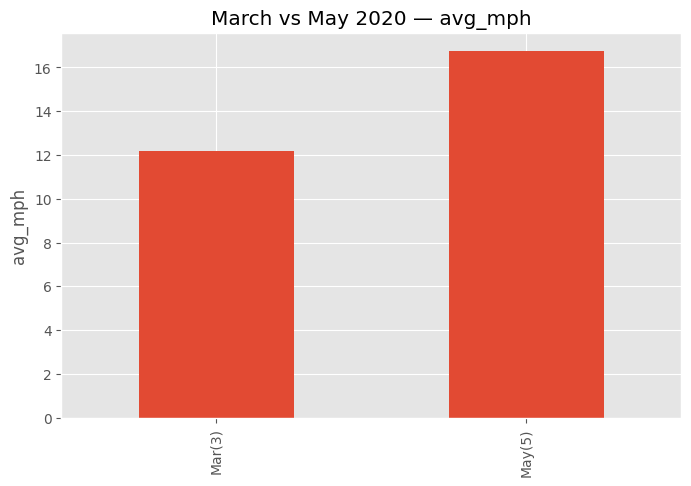

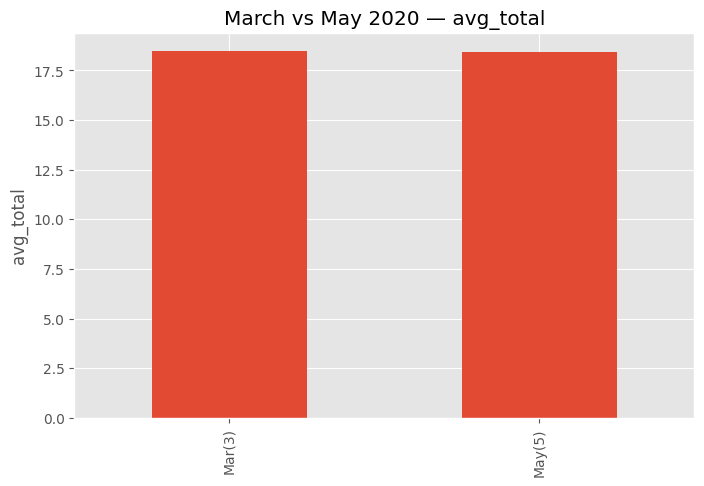

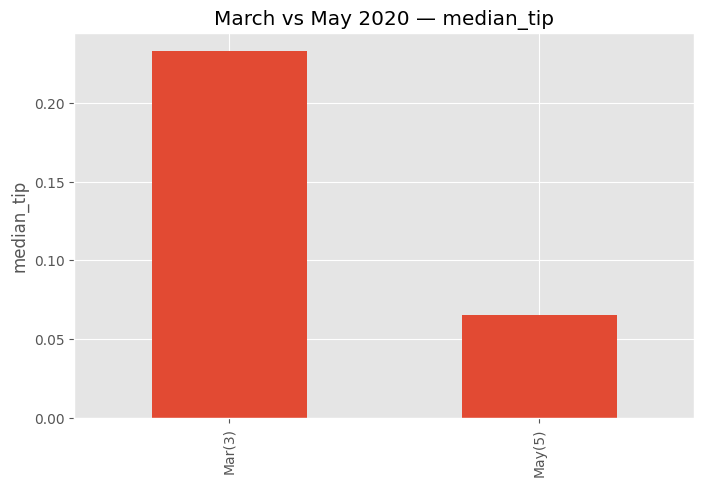

Delta (May - March): {'trips': -2620072.0, 'avg_distance': 0.8979999999999997, 'avg_duration': -1.2199999999999989, 'avg_mph': 4.552999999999999, 'avg_total': -0.038999999999997925, 'median_tip': -0.168}


In [11]:
import math

metrics = {
    "trips"        : lambda g: len(g),
    "avg_distance" : lambda g: g["trip_distance"].mean(),
    "avg_duration" : lambda g: g["trip_duration_min"].mean(),
    "avg_mph"      : lambda g: g["avg_mph"].mean(),
    "avg_total"    : lambda g: g["total_amount"].mean(),
    "median_tip"   : lambda g: g["tip_rate"].median(),
}

def kpis(df):
    return pd.Series({k: fn(df) for k, fn in metrics.items()})

cmp_35 = pd.concat(
    {"Mar(3)": kpis(mar), "May(5)": kpis(may)}, axis=1
).round(3).T

display(cmp_35)

# Plot a few
for col in cmp_35.columns:
    ax = cmp_35[col].plot(kind="bar", title=f"March vs May 2020 — {col}")
    ax.set_ylabel(col); ax.set_xlabel("")
    plt.show()

print("Delta (May - March):", (cmp_35.loc["May(5)"] - cmp_35.loc["Mar(3)"]).to_dict())

## 12 — KPI comparison: Jan vs March 2020 (+ charts & delta)


,trips,avg_distance,avg_duration_min,avg_mph,avg_total,median_tip_rate
Jan(1),6294833.0,2.931,13.187,11.879,18.570,0.235
Mar(3),2955781.0,2.914,13.139,12.193,18.476,0.233


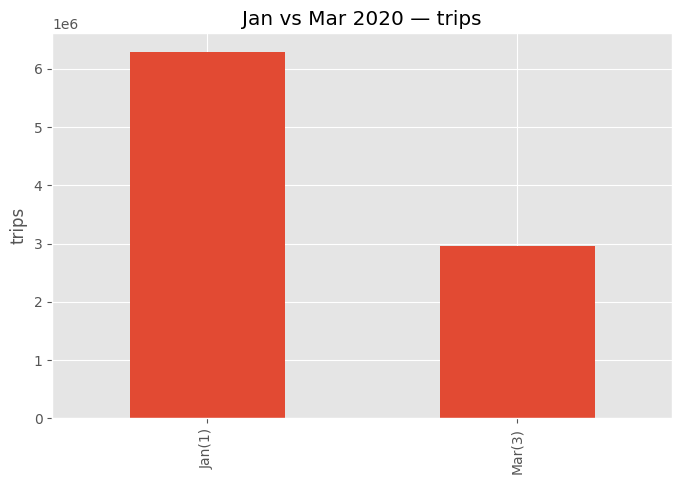

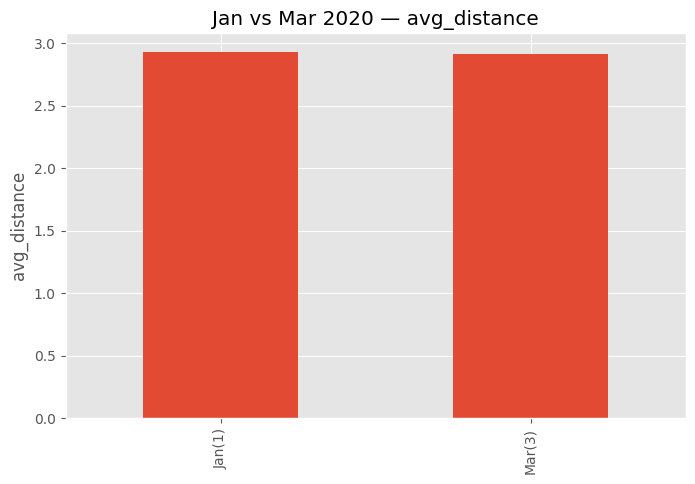

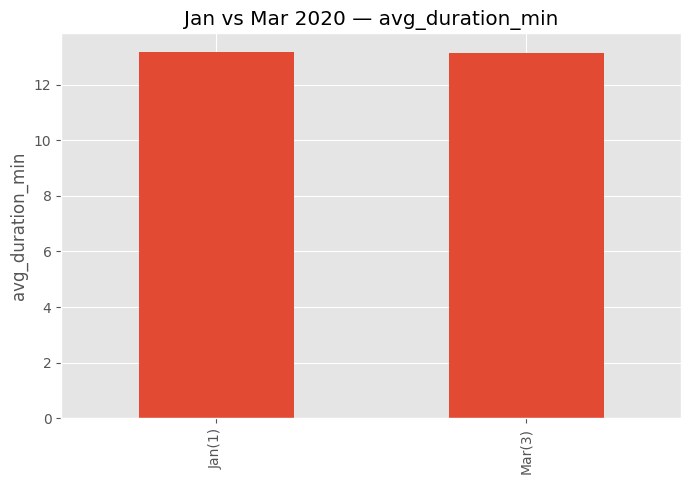

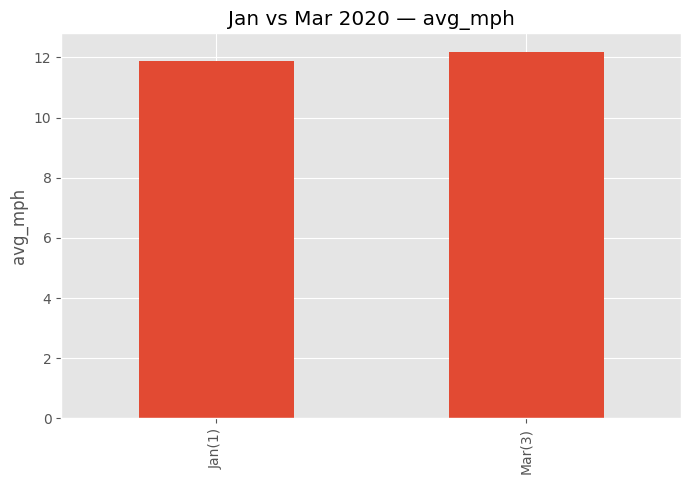

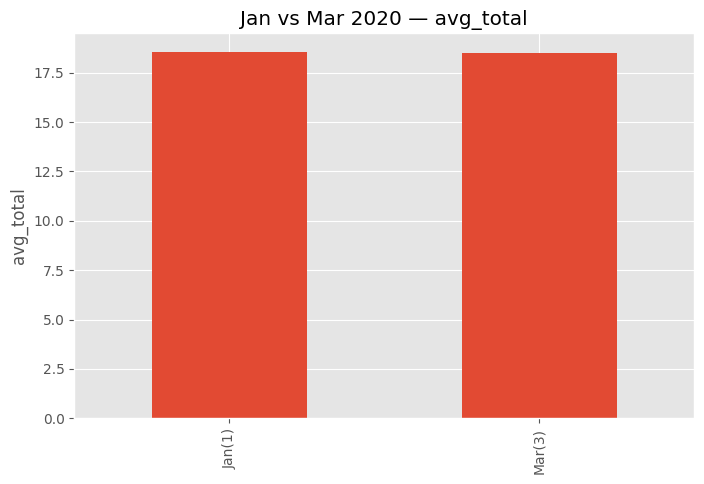

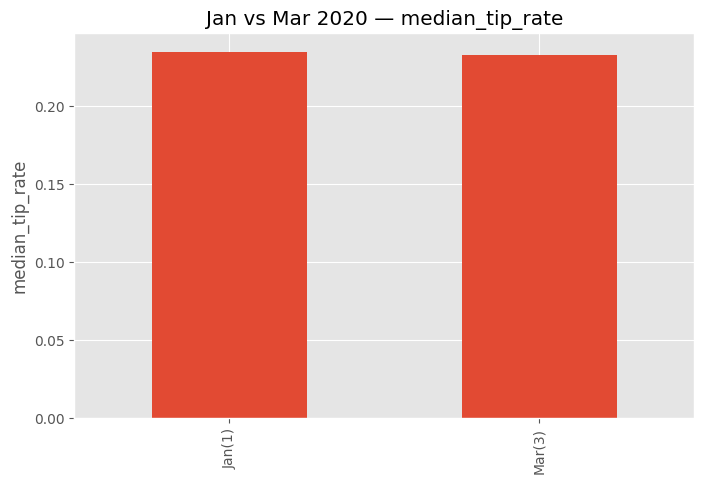

Delta (Mar - Jan): {'trips': -3339052.0, 'avg_distance': -0.016999999999999904, 'avg_duration_min': -0.04800000000000004, 'avg_mph': 0.31400000000000006, 'avg_total': -0.0940000000000012, 'median_tip_rate': -0.001999999999999974}


In [12]:
metrics2 = {
    "trips"           : lambda g: len(g),
    "avg_distance"    : lambda g: g["trip_distance"].mean(),
    "avg_duration_min": lambda g: g["trip_duration_min"].mean(),
    "avg_mph"         : lambda g: g["avg_mph"].mean(),
    "avg_total"       : lambda g: g["total_amount"].mean(),
    "median_tip_rate" : lambda g: g["tip_rate"].median(),
}

def kpis2(df):
    return pd.Series({k: fn(df) for k, fn in metrics2.items()})

cmp_13 = pd.concat(
    {"Jan(1)": kpis2(jan), "Mar(3)": kpis2(mar)}, axis=1
).round(3).T

display(cmp_13)

for col in cmp_13.columns:
    ax = cmp_13[col].plot(kind="bar", title=f"Jan vs Mar 2020 — {col}")
    ax.set_ylabel(col); ax.set_xlabel("")
    plt.show()

print("Delta (Mar - Jan):", (cmp_13.loc["Mar(3)"] - cmp_13.loc["Jan(1)"]).to_dict())


## 13 — Save prepared datasets (train/eval to Parquet/CSV)

In [13]:
from pathlib import Path
Path("prepared").mkdir(exist_ok=True)

mar.to_parquet("prepared/train_mar2020.parquet", index=False)
may.to_parquet("prepared/eval_may2020.parquet", index=False)

# If your professor prefers CSV:
# mar.to_csv("prepared/train_mar2020.csv", index=False)
# may.to_csv("prepared/eval_may2020.csv", index=False)

print("Saved:", os.listdir("prepared"))

Saved: ['eval_may2020.parquet', 'train_mar2020.parquet']


# NYC Yellow Taxi — EDA & Insights (2020)

## KPI Snapshots

### March vs May 2020
| Metric                  | March (3) | May (5) | Δ (May − Mar) |
|-------------------------|-----------|---------|---------------|
| **Trips**               | 2,955,781 | 335,709 | **−2,620,072** (−88.6%) |
| **Avg. Distance (mi)**  | 2.914     | 3.812   | **+0.898** (+30.8%) |
| **Avg. Duration (min)** | 13.139    | 11.919  | **−1.220** (−9.3%) |
| **Avg. Speed (mph)**    | 12.193    | 16.746  | **+4.553** (+37.3%) |
| **Avg. Total ($)**      | 18.476    | 18.437  | −0.039 (−0.2%) |
| **Median Tip Rate**     | 0.233     | 0.065   | **−0.168** (−72.1%) |

**What this means.** Travel demand fell dramatically in May. The trips that remained tended to be longer and faster, consistent with lighter traffic and more essential travel. Median tipping fell sharply, likely reflecting tighter budgets and/or shifts in how rides were paid.

---

### January vs March 2020
| Metric                  | January (1) | March (3) | Δ (Mar − Jan) |
|-------------------------|-------------|-----------|---------------|
| **Trips**               | 6,294,833   | 2,955,781 | **−3,339,052** (−53.0%) |
| **Avg. Distance (mi)**  | 2.931       | 2.914     | −0.017 (−0.6%) |
| **Avg. Duration (min)** | 13.187      | 13.139    | −0.048 (−0.36%) |
| **Avg. Speed (mph)**    | 11.879      | 12.193    | **+0.314** (+2.6%) |
| **Avg. Total ($)**      | 18.570      | 18.476    | −0.094 (−0.5%) |
| **Median Tip Rate**     | 0.235       | 0.233     | −0.002 (−0.9%) |

**What this means.** The drop in activity began in March, but trip length and duration still looked close to January. The big behavioral shifts show up by May.

---

## EDA Highlights

- **Distance and time move together.** Trip distance is the strongest practical driver of trip duration.  
- **Fare components overlap.** `fare_amount`, `extra`, `mta_tax`, and `total_amount` are correlated; keep a representative field to avoid redundancy.  
- **Data hygiene.** Removed impossible values, capped extreme durations, and kept speeds within a reasonable band (1–80 mph).

---

## Recommendations (for modeling)

1. **Useful features:** trip distance, pickup/dropoff hour and weekday, `PULocationID`, `DOLocationID`, and `payment_type`.  
2. **Reduce redundancy:** if `total_amount` is included, consider dropping highly collinear add-ons like `extra` and `mta_tax`.  
3. **Pick the time window to match the question:**  
   - For pre-COVID patterns, use **January–March 2020**.  
   - To capture the “new normal,” include **May 2020** as well.  
4. **If modeling duration:** predict `trip_duration_min` from distance, time-of-day, and zones; evaluate with **MAE**.

---

## Conclusion

- Trip volume fell by half from January to March and by almost ninety percent by May.  
- By May, the trips that remained were longer and moved faster, which fits with much lower congestion and more purpose-driven travel.  
- Average spend per trip stayed roughly flat, while median tipping dropped a lot.  
- The dataset is clean and mostly numeric, with clear features to keep and a few fare components that can be consolidated—meeting the project’s EDA and insight requirements.
